# BIOS470/570 Lecture 9

## Last time we covered:
* ### Clustering data 
* ### seaborn plotting package
* ### Gene ontology with gget

## Today we will cover:
* ### Dimensionality reduction with PCA. 

#### We will use the pca command from the scikit-learn library which has many functions for machine learning. 
#### Install command: conda install scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition, preprocessing

### Data that goes into PCA is often scaled to avoid the variance being dominated by the components with the largest numbers. Let's look at a simple example of this scaling:

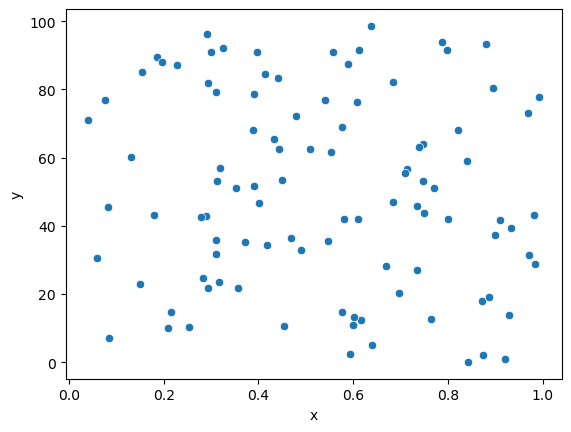

In [2]:
# Make a dataframe with random data in columns labeled x and y:
rand_data = pd.DataFrame({'x':np.random.random(100),'y':100*np.random.random(100)})
# use seaborn to scatterplot:
sns.scatterplot(rand_data, x = 'x', y = 'y');

### This applies a standard scaling from the scikit-learn library. The standard scaling is for each variable to subtract its mean and divide by its standard deviation: i.e. $x_{scaled} = (x - \langle x \rangle )/ \rm{std}(x)$

### This shows how many of the functions of the scikit-learn work. You define the model and then fit it, which actually runs the algorithm. The fit modifies the model object in place. Then, running the transform command actually returns the transformed data. 


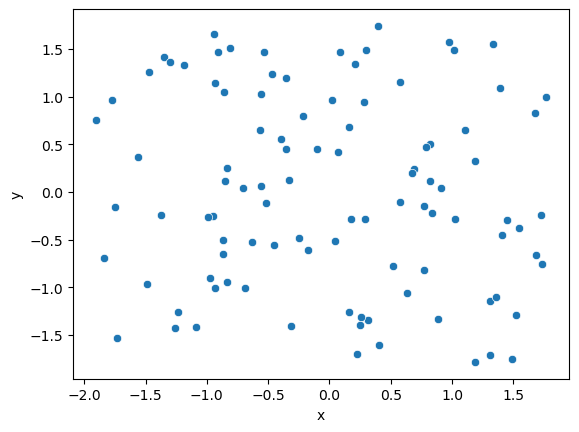

In [3]:
scaler = preprocessing.StandardScaler()
scaler.fit(rand_data)
# By default sklearn outputs this as a numpy array, but we can put it back into a dataframe:
new_data = pd.DataFrame(scaler.transform(rand_data),columns=rand_data.columns)
sns.scatterplot(new_data,x = 'x',y = 'y');

### Now let's look at a dataset with a correlation between x and y. 

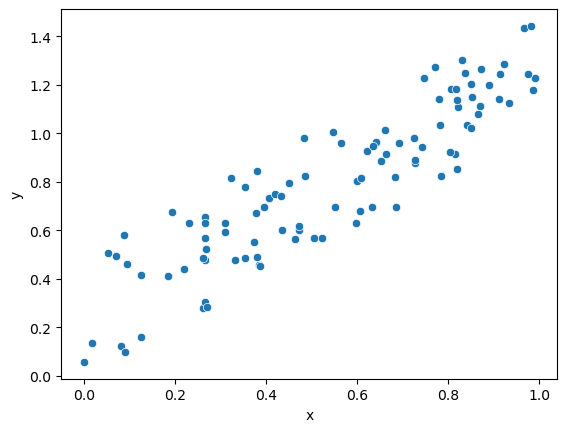

In [4]:
# define some random numbers
x = np.random.random(100)
# a data frame where x are the random numbers and y is x with added noise. 
rand_data = pd.DataFrame({'x':x,'y':x+0.5*np.random.random(100)})
#make a scatterplot of the dataframe
sns.scatterplot(rand_data, x = 'x', y = 'y');

### Let's apply the same standard scaler to the data, it will look basically the same but the means will have shifted, and the scale changed.  

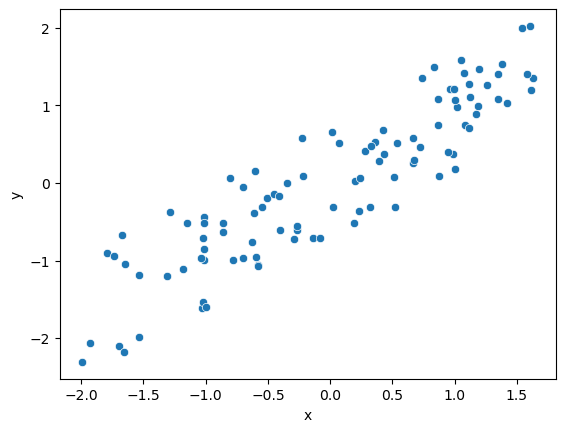

In [9]:
scaler = preprocessing.StandardScaler() #make the scalar object
scaler.fit(rand_data) #apply it to the data
new_data = pd.DataFrame(scaler.transform(rand_data), columns=rand_data.columns) #get the transformed data
sns.scatterplot(new_data, x = 'x',y = 'y'); #plot it

### Now let's apply PCA to this dataset. First, we make the pca model object with decomposition.pca, then we run fit to actual do the PCA. This will add some variables into the model. First, let's look at explained variance ratio:

In [10]:
pca = decomposition.PCA(n_components=2)
pca.fit(new_data)
pca.explained_variance_ratio_

array([0.95048268, 0.04951732])

### There are two components to the PCA, because that is how many we specified. That is also the maximum number because the originail data was 2 dimensional.  ~95% of the variance in the data can be explained by the first component. 

### Now let's get the transformed data. We will put it in a new dataframe with the columns labeled pc1 and pc2:

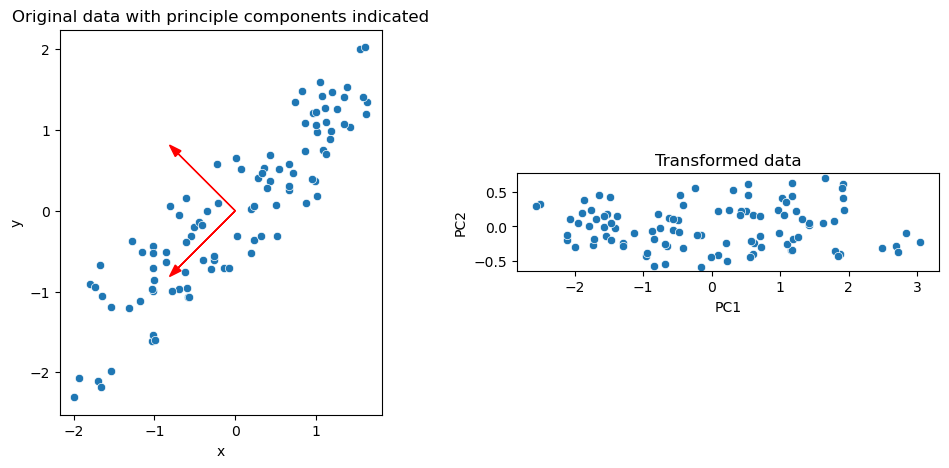

In [13]:
transformed_data = pd.DataFrame(pca.transform(new_data), columns=['PC1','PC2'])
#axes[0].scatter(new_data[:,0],new_data[:,1])
fig = plt.figure(figsize = (12,5))
axes = fig.subplots(1,2)
sns.scatterplot(new_data, x = 'x',y='y',ax = axes[0])
axes[0].arrow(0,0, pca.components_[0,0], pca.components_[0,1], head_width = 0.1, color = 'r', label = 'pc1')
axes[0].arrow(0,0, pca.components_[1,0], pca.components_[1,1], head_width = 0.1, color = 'r')
axes[0].set_aspect('equal')
axes[0].set_title('Original data with principle components indicated')
sns.scatterplot(transformed_data, x = 'PC1', y = 'PC2', ax = axes[1])
axes[1].set_title('Transformed data')
axes[1].set_aspect('equal')

In [45]:
pca.components_

array([[-0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678]])

In [106]:
#data = pd.read_excel('data/GSE137492_SupplementaryTable1.xlsx')
data = pd.read_csv('data/xen_uic_hik_stage8_13_30min.tsv',delimiter='\t')

In [120]:
data_numeric = data.iloc[:,1:].transpose().to_numpy()
data_numeric.shape
scaler = preprocessing.StandardScaler()
scaler.fit(data_numeric)
data_scaled = scaler.transform(data_numeric)

In [121]:
out = decomposition.PCA(n_components=10)

In [122]:
tt = out.fit_transform(data_scaled)

In [123]:
out.explained_variance_ratio_

array([0.35482574, 0.10235498, 0.08042491, 0.05996183, 0.0351217 ,
       0.03055569, 0.02831882, 0.02392787, 0.02162469, 0.02044505])

In [124]:
type(out)

sklearn.decomposition._pca.PCA

In [125]:
tt.shape

(26, 10)